In [1]:
import numpy as np 
import os
import sys
import xarray as xr
import scipy.io as sio
import matplotlib.pyplot as plt
import datetime

from dotenv import load_dotenv, find_dotenv

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()
load_dotenv(dotenv_path)
src_dir = os.environ.get('srcdir')
sys.path.append(src_dir)

# always reload modules marked with "%aimport"
%load_ext autoreload
%autoreload 1

from features.grid_ttide import NDinterp
from features.log_progress import log_progress
from scipy.ndimage.filters import gaussian_filter

#run = os.environ.get('run')
run ='waom10_robust'

In [2]:
#read in tamura land mask
T_mask_path = os.path.join(os.environ.get('extdir'),'tamura','EASE_landmask_H.data')
with open(T_mask_path,'rb') as fid:
    T_mask = np.fromfile(fid,count=(721*721),dtype='float32').reshape((721,721))
    T_mask = np.flipud(T_mask)

In [3]:
#get tamura lat lon coordinates
T_lat_lon_path = os.path.join(os.environ.get('extdir'),'tamura','latlon.data')
with open(T_lat_lon_path,'rb') as fid:
    T_lat_lon = np.fromfile(fid,count=(721*721*2),dtype='float32').reshape((2,721,721))
T_lat,T_lon = (T_lat_lon[0],T_lat_lon[1])
T_lat = np.flipud(T_lat)
T_lon = np.flipud(T_lon)

In [4]:
#read in era interim winds and resample from twice daily to daily
era_path = os.path.join(os.environ.get('extdir'),'era_interim','ERA_Interim_1992_2011.2daily.*winds.nc')
era_ds = xr.open_mfdataset(era_path,data_vars='minimal').sel(time='2007',latitude=slice(-30,-90)).resample(time='D').mean()

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


In [5]:
#get era coordinates
era_lat = era_ds.latitude.values
era_lon = era_ds.longitude.values
era_lon[era_lon>180]-=360.0
E_lon,E_lat = np.meshgrid(era_lon,era_lat)

In [6]:
#get roms grid
R_grid_path = os.path.join(os.environ.get('prodir'),run+'_grd.nc')
R_grid = xr.open_dataset(R_grid_path)
R_lon = R_grid.lon_rho.values
R_lat = R_grid.lat_rho.values
R_angle = R_grid.angle.values
R_ulon = R_grid.lon_u.values
R_vlon = R_grid.lon_v.values
R_ulat = R_grid.lat_u.values
R_vlat = R_grid.lat_v.values

In [7]:
from scipy.interpolate import NearestNDInterpolator

def NDinterp(data):

    valid_mask = ~np.isnan(data)
    coords = np.array(np.nonzero(valid_mask)).T
    values = data[valid_mask]

    it = NearestNDInterpolator(coords,values)

    filled = it(list(np.ndindex(data.shape))).reshape(data.shape)

    return filled

In [7]:
from pyresample import kd_tree, geometry, utils

E_lon, E_lat = utils.check_and_wrap(E_lon,E_lat)
T_lon, T_lat = utils.check_and_wrap(T_lon,T_lat)

T_def = geometry.SwathDefinition(lons=T_lon,lats=T_lat)
E_def = geometry.SwathDefinition(lons=E_lon,lats=E_lat)
R_def = geometry.SwathDefinition(lons=R_lon,lats=R_lat)
RV_def = geometry.SwathDefinition(lons=R_vlon,lats=R_vlat)
RU_def = geometry.SwathDefinition(lons=R_ulon,lats=R_ulat)

valid_input_index_T2R, valid_output_index_T2R, index_array_T2R, distance_array_T2R = \
kd_tree.get_neighbour_info(T_def,R_def, 10000,neighbours=4,nprocs=16)

wf_T2R = lambda r: 1/r

valid_input_index_E2RU, valid_output_index_E2RU, index_array_E2RU, distance_array_E2RU = \
kd_tree.get_neighbour_info(E_def,RU_def, 500000,neighbours=16,nprocs=16)

valid_input_index_E2RV, valid_output_index_E2RV, index_array_E2RV, distance_array_E2RV = \
kd_tree.get_neighbour_info(E_def,RV_def, 500000,neighbours=16,nprocs=16)

sigma = 250000
wf_E2R = lambda r: np.exp(-r**2/sigma**2)

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/pyresample/kd_tree.py:399: UserWarning: Possible more than 4 neighbours within 10000 m for some data points
  (neighbours, radius_of_influence))
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/pyresample/kd_tree.py:399: UserWarning: Possible more than 16 neighbours within 500000 m for some data points
  (neighbours, radius_of_influence))


In [8]:
wf = lambda r: 1/r
R_angle_on_E_grd = kd_tree.resample_custom(R_def,R_angle,E_def,radius_of_influence=10000, weight_funcs=wf)

In [11]:
month = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
month_nb = ['01','02','03','04','05','06','07','08','09','10','11','12']
daysPerMonth = [31,28,31,30,31,30,31,31,30,31,30,31]

#month = ['nov']
#month_nb = ['11']
#daysPerMonth = [30]

#month = ['jan']
#daysPerMonth = [1]

dayOfYear = 1

for month,days,month_nb in zip(month,daysPerMonth,month_nb):
    
    print('Processing month: ',month,'with days: ',days)
    
    daysOfYear = np.arange(dayOfYear,dayOfYear+days,dtype=int)
    
    print('Containing days of year: ',daysOfYear)

    # preparing empty dataset
    ds = xr.Dataset({'shflux':(['shf_time','eta_rho','xi_rho'], np.empty((days,R_grid.eta_rho.size,R_grid.xi_rho.size))),
                     'swflux':(['swf_time','eta_rho','xi_rho'], np.empty((days,R_grid.eta_rho.size,R_grid.xi_rho.size))),
                     'sustr':(['sms_time','eta_u','xi_u'], np.empty((days,R_grid.eta_u.size,R_grid.xi_u.size))),
                     'svstr':(['sms_time','eta_v','xi_v'], np.empty((days,R_grid.eta_v.size,R_grid.xi_v.size)))},
                   coords={'shf_time':(['shf_time'],daysOfYear),
                           'swf_time':(['swf_time'],daysOfYear),
                           'sms_time':(['sms_time'],daysOfYear)})
   
    #open Tamura month flux data 
    T_data_path = os.path.join(os.environ.get('extdir'),'tamura','TSDM2hb_2007_'+month+'.data')
    with open(T_data_path,'rb') as fid:
        T_data = np.swapaxes(np.fromfile(fid,count = days*6*721*721 ,dtype='float32').reshape(days,6,721,721),0,1)
    
    #looping over the days with running day-of-the-year and day-of-the-month index
    for Eidx,Tidx in zip(log_progress(daysOfYear-1,name='days'),np.arange(days)):
        
        #read in Tamura heat and fresh water flux and turn in right position
        shflux_tmp = np.flipud(T_data[0,Tidx])
        ssflux_tmp = np.flipud(T_data[2,Tidx])
        
        #fill in tamuar mask for later resampling
        shflux_tmp[T_mask==0] = np.nan
        shflux_tmp = NDinterp(shflux_tmp)
        
        ssflux_tmp[T_mask==0] = np.nan
        ssflux_tmp = NDinterp(ssflux_tmp)

        #resample to roms grid points
        shflux_tmp = kd_tree.get_sample_from_neighbour_info('custom', R_def.shape, shflux_tmp,\
                                             valid_input_index_T2R,\
                                             valid_output_index_T2R,index_array_T2R,distance_array_T2R,wf_T2R)

        ssflux_tmp = kd_tree.get_sample_from_neighbour_info('custom', R_def.shape, ssflux_tmp,\
                                             valid_input_index_T2R,\
                                             valid_output_index_T2R,index_array_T2R,distance_array_T2R,wf_T2R)
        
        #correct large summer heat flux values and save to dataset
        shflux_tmp[shflux_tmp > 0.0]*=0.5
        
        ds.shflux[Tidx] = shflux_tmp
        del shflux_tmp
        
        #convert to freshwater flux with convention positive up 'swf (E-P)',
        #that means a positive freshwater flux value results in positive salt flux value
        #and save to dataset
        refSalt = 34.4

        ds.swflux[Tidx] = ssflux_tmp/refSalt*100
        del ssflux_tmp
        
        #select era-interim winds
        uwnd = era_ds.u10[Eidx].values
        vwnd = era_ds.v10[Eidx].values

        #rotate wind directions to roms grid
        uv = (uwnd+1j*vwnd)*np.exp(1j*-R_angle_on_E_grd)
        uwnd = uv.real
        vwnd = uv.imag
        
        #convert to stress
        signu = np.sign(uwnd)
        signv = np.sign(vwnd)

        rhoAir = 1.3
        Cd = 1.4e-3

        taux = rhoAir*Cd*np.square(uwnd)*signu
        tauy = rhoAir*Cd*np.square(vwnd)*signv
        del uwnd, vwnd
        
        #resample to roms u and v grid and save to dataset
        taux = kd_tree.get_sample_from_neighbour_info('custom', RU_def.shape, taux,\
                                             valid_input_index_E2RU,\
                                             valid_output_index_E2RU,index_array_E2RU,distance_array_E2RU,wf_E2R)
        
        tauy = kd_tree.get_sample_from_neighbour_info('custom', RV_def.shape, tauy,\
                                             valid_input_index_E2RV,\
                                             valid_output_index_E2RV,index_array_E2RV,distance_array_E2RV,wf_E2R)
        
        
        #smooth with gaussian filter and put in dataset
        ds.sustr[Tidx]= gaussian_filter(taux,60)
        ds.svstr[Tidx]= gaussian_filter(tauy,60)
        del taux, tauy
        
    #add attributes to data set and data arrays
    ds.attrs={'title':'waom surface heat/fresh water fluxes and wind stress',
                          'date':str(datetime.date.today()),
                          'tamura_file':T_data_path,
                          'era-interim file':era_path,
                          'grid file':R_grid_path,
                          'type':'ROMS forcing file'}
    ds.shflux.attrs = {'long_name': 'surface net heat flux', 'units': 'Watts meter-2'}
    ds.swflux.attrs = {'long_name': 'surface freshwater flux (E-P)',
                       'negative': 'net precipitation',
                       'positive': 'net evaporation',
                       'units': 'centimetre day-1'}
    ds.sustr.attrs = {'long_name': 'surface u-momentum stress', 'units': 'Newton meter-2'}
    ds.svstr.attrs = {'long_name': 'surface u-momentum stress', 'units': 'Newton meter-2'}
    ds.sms_time.attrs = {'cycle_length': days,'long_name': 'surface momentum stress time','units': 'day'}
    ds.shf_time.attrs = {'cycle_length': days, 'long_name': 'surface heat flux time', 'units': 'day'}
    ds.swf_time.attrs = {'cycle_length': days,'long_name': 'surface freshwater flux time','units': 'day'}
    
    #save month as netcdf files
    for var,dim in zip(['shflux','swflux','sustr','svstr'],['shf_time','swf_time','sms_time','sms_time']):
        out_path = os.path.join('/home/ubuntu/raijin/g/data2/gh9/oxr581/waom1_frc',var+'_'+month_nb+'.nc')
        print("Saving month to "+out_path)
        ds[var].to_netcdf(out_path,'w',unlimited_dims=dim)
    del ds
    
    #update the day of the year value for next month
    dayOfYear += days

Processing month:  jan with days:  31
Containing days of year:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31]


VBox(children=(HTML(value=''), IntProgress(value=0, max=31)))

KeyboardInterrupt: 

In [18]:
for var,dim in zip(['shflux','swflux','sustr','svstr'],['shf_time','swf_time','sms_time','sms_time']):
    out_path = os.path.join('/home/ubuntu/raijin/g/data2/gh9/oxr581/waom1_frc',var+'_'+month_nb+'.nc')
    print("Saving month to "+out_path)
    ds[var].to_netcdf(out_path,'w',unlimited_dims=dim)

Saving month to /home/ubuntu/raijin/g/data2/gh9/oxr581/waom1_frc/shflux_11.nc
Saving month to /home/ubuntu/raijin/g/data2/gh9/oxr581/waom1_frc/swflux_11.nc
Saving month to /home/ubuntu/raijin/g/data2/gh9/oxr581/waom1_frc/sustr_11.nc
Saving month to /home/ubuntu/raijin/g/data2/gh9/oxr581/waom1_frc/svstr_11.nc


In [12]:
del ds

In [20]:
ds.shflux.to_netcdf(out_path,unlimited_dims='shf_time')

In [6]:
import os
import xarray as xr
import glob

run = 'waom2_small'


# concatenate all monthly data into a single file
monthly_data_paths = os.path.join('/home/ubuntu/raijin/g/data2/gh9/oxr581/waom2_frc',run+'_sbc_*.nc')
for file in glob.glob(monthly_data_paths):
    print('loading: '+file)

ds = xr.open_mfdataset(monthly_data_paths,concat_dim=None)

loading: /home/ubuntu/raijin/g/data2/gh9/oxr581/waom2_frc/waom2_small_sbc_mar.nc
loading: /home/ubuntu/raijin/g/data2/gh9/oxr581/waom2_frc/waom2_small_sbc_sep.nc
loading: /home/ubuntu/raijin/g/data2/gh9/oxr581/waom2_frc/waom2_small_sbc_aug.nc
loading: /home/ubuntu/raijin/g/data2/gh9/oxr581/waom2_frc/waom2_small_sbc_jun.nc
loading: /home/ubuntu/raijin/g/data2/gh9/oxr581/waom2_frc/waom2_small_sbc_feb.nc
loading: /home/ubuntu/raijin/g/data2/gh9/oxr581/waom2_frc/waom2_small_sbc_nov.nc
loading: /home/ubuntu/raijin/g/data2/gh9/oxr581/waom2_frc/waom2_small_sbc_apr.nc
loading: /home/ubuntu/raijin/g/data2/gh9/oxr581/waom2_frc/waom2_small_sbc_oct.nc
loading: /home/ubuntu/raijin/g/data2/gh9/oxr581/waom2_frc/waom2_small_sbc_dec.nc
loading: /home/ubuntu/raijin/g/data2/gh9/oxr581/waom2_frc/waom2_small_sbc_may.nc
loading: /home/ubuntu/raijin/g/data2/gh9/oxr581/waom2_frc/waom2_small_sbc_jan.nc
loading: /home/ubuntu/raijin/g/data2/gh9/oxr581/waom2_frc/waom2_small_sbc_jul.nc


KeyboardInterrupt: 

In [55]:
for time in range(ds.sms_time.size):
    print(time)
    ds.sustr.values[time] = gaussian_filter(ds.sustr[time].values,9)
    ds.svstr.values[time] = gaussian_filter(ds.svstr[time].values,9)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [57]:
ds.to_netcdf(os.path.join(os.environ.get('prodir'),'waom10_small_sbc_smooth.nc'))

In [ ]:
#ds = ds.chunk(chunks={'eta_rho':100,'xi_rho':100,\
                      #'eta_u':100,'xi_u':100,'eta_v':100,'xi_v':100,\
                      #'shf_time':3,'swf_time':3,'sms_time':3})
for time in ['shf_time','swf_time','sms_time']:
    ds[time]['cycle_length'] = float(365)
year_data_path = os.path.join('/home/ubuntu/raijin/g/data2/gh9/oxr581/waom2_frc',run+'_sbc.nc')

print('and saving to '+year_data_path)
#ds.to_netcdf(year_data_path)

In [2]:
data_paths = os.path.join('/home/ubuntu/raijin/g/data2/gh9/oxr581/waom2_frc','waom2_small_sbc_shflux.nc')
shf = xr.open_dataset(data_paths)

In [4]:
shf.sortby(shf.shf_time)

<xarray.Dataset>
Dimensions:   (eta_rho: 2650, shf_time: 365, xi_rho: 3150)
Coordinates:
  * shf_time  (shf_time) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    shflux    (shf_time, eta_rho, xi_rho) float64 69.82 69.81 69.82 69.49 ...
Attributes:
    title:                     waom surface heat/fresh water fluxes and wind ...
    date:                      2018-05-07
    tamura_file:               /home/ubuntu/bigStick/tidal_melting/data/prepr...
    era-interim file:          /home/ubuntu/bigStick/tidal_melting/data/prepr...
    grid file:                 /home/ubuntu/bigStick/tidal_melting/data/prepr...
    type:                      ROMS forcing file
    nco_openmp_thread_number:  1
    history:                   Tue May  8 19:30:45 2018: ncatted -a cycle_len...
    NCO:                       "4.6.4"

# BELOW JUST DEVEL STUFF

In [8]:
#open Tamura month flux data 
T_data_path = os.path.join(os.environ.get('extdir'),'tamura','TSDM2hb_2007_jan.data')
with open(T_data_path,'rb') as fid:
    T_data = np.swapaxes(np.fromfile(fid,count = 31*6*721*721 ,dtype='float32').reshape(31,6,721,721),0,1)

In [156]:
Eidx=0
uwnd = era_ds.u10[Eidx].values
vwnd = era_ds.v10[Eidx].values

        #uwnd = resample(E_lon,E_lat,R_lon,R_lat,era_ds.u10[Eidx].values)
        #vwnd = resample(E_lon,E_lat,R_lon,R_lat,era_ds.v10[Eidx].values)

#rotate wind directions to roms grid
uv = (uwnd+1j*vwnd)*np.exp(1j*-R_angle_on_E_grd)
uwnd = uv.real
vwnd = uv.imag

#convert to stress
signu = np.sign(uwnd)
signv = np.sign(vwnd)

rhoAir = 1.3
Cd = 1.4e-3

taux = rhoAir*Cd*np.square(uwnd)*signu
tauy = rhoAir*Cd*np.square(vwnd)*signv



In [126]:
E2lon,E2lat = pyresample.utils.check_and_wrap(E_lon,E_lat)

In [131]:
E_lon.shape

(41, 240)

In [132]:
E2lon.shape

(41, 240)

<IPython.core.display.Javascript object>


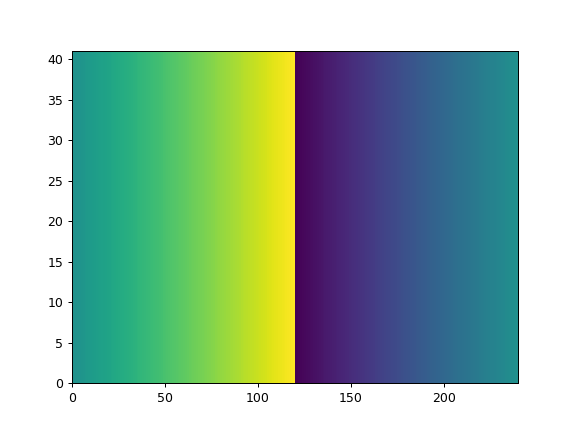

In [129]:
plt.close()
plt.pcolormesh(E2lon)
plt.show()

In [136]:
(E2lon!=E_lon).any()

True

In [157]:
E_def = geometry.SwathDefinition(lons=E2lon,lats=E2lat)
sigma = 500000
wf = lambda r: np.exp(-r**2/sigma**2)
valid_input_index_E2RU, valid_output_index_E2RU, index_array_E2RU, distance_array_E2RU = \
kd_tree.get_neighbour_info(E_def,RU_def, 500000,neighbours=16,nprocs=16)
#resample to roms u and v grid and save to dataset
ds.sustr[Tidx] = kd_tree.get_sample_from_neighbour_info('custom', RU_def.shape, taux,\
                                     valid_input_index_E2RU,\
                                     valid_output_index_E2RU,index_array_E2RU,distance_array_E2RU,wf)

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/pyresample/kd_tree.py:399: UserWarning: Possible more than 16 neighbours within 500000 m for some data points
  (neighbours, radius_of_influence))


<IPython.core.display.Javascript object>


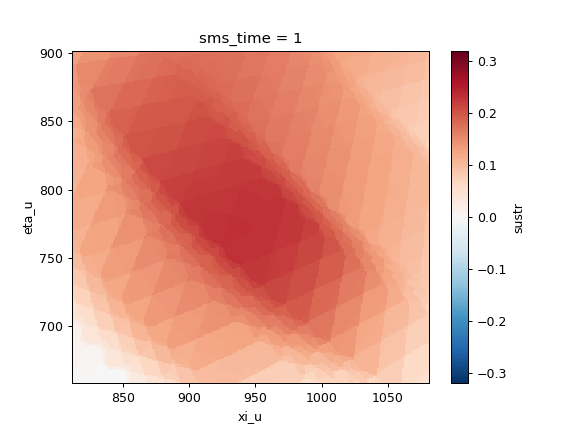

In [158]:
plt.close()
ds.sustr[0].plot()
plt.show()

In [165]:
gauss50 = gaussian_filter(ds.sustr[0],20)

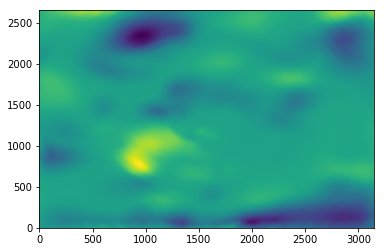

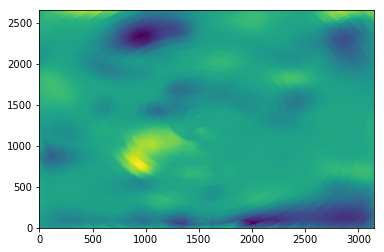

In [168]:
%matplotlib inline
plt.close()
plt.pcolormesh(gauss50)
plt.show()
plt.pcolormesh(ds.sustr[0])
plt.show()

In [64]:
channel1 = np.fromfunction(lambda y, x: y*x, (50, 10))
channel2 = np.fromfunction(lambda y, x: y*x, (50, 10)) * 2
channel3 = np.fromfunction(lambda y, x: y*x, (50, 10)) * 3
data = np.dstack((channel1, channel2, channel3))
data.shape[1]

10

<IPython.core.display.Javascript object>


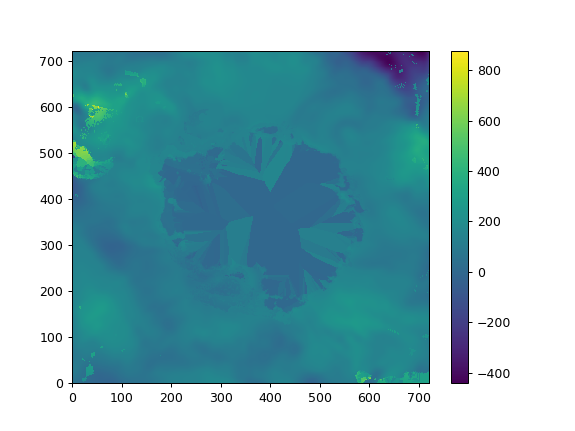

In [87]:
plt.close()
plt.pcolormesh(data)
plt.colorbar()
plt.show()

In [77]:
kd_tree.get_neighbour_info?

In [71]:
%%time
from pyresample import kd_tree, geometry


source_def = geometry.SwathDefinition(lons=T_lon,lats=T_lat)
target_def = geometry.SwathDefinition(lons=R_lon,lats=R_lat)

result = kd_tree.resample_gauss(source_def,data,target_def,radius_of_influence=10000,sigmas=25000,nprocs=16)

CPU times: user 50.7 s, sys: 2.86 s, total: 53.6 s
Wall time: 20 s


In [91]:
%%time
from pyresample import kd_tree, geometry


source_def = geometry.SwathDefinition(lons=T_lon,lats=T_lat)
target_def = geometry.SwathDefinition(lons=R_lon,lats=R_lat)

valid_input_index, valid_output_index, index_array, distance_array = \
kd_tree.get_neighbour_info(source_def,target_def, 10000,neighbours=4,nprocs=16)
wf = lambda r: 1/r

res = kd_tree.get_sample_from_neighbour_info('custom', target_def.shape, data,\
                                             valid_input_index,\
                                             valid_output_index,index_array,distance_array,wf)


/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/pyresample/kd_tree.py:399: UserWarning: Possible more than 4 neighbours within 10000 m for some data points
  (neighbours, radius_of_influence))


CPU times: user 38.4 s, sys: 1.03 s, total: 39.5 s
Wall time: 8.31 s


In [79]:
%%time
res = kd_tree.get_sample_from_neighbour_info('custom', target_def.shape, data,\
                                             valid_input_index,\
                                             valid_output_index,index_array,distance_array,wf)


CPU times: user 9.87 s, sys: 2.62 s, total: 12.5 s
Wall time: 12.5 s


<IPython.core.display.Javascript object>


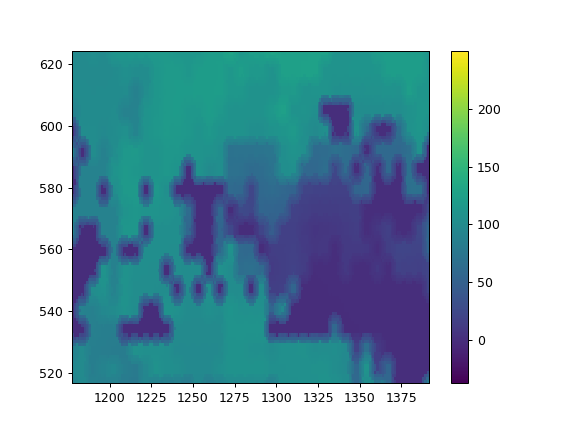

In [92]:
%matplotlib notebook
plt.close()
plt.pcolormesh(res)
plt.colorbar()
plt.contour(R_grid.mask_rho.values)

plt.show()

In [53]:
%%time
from pyresample import kd_tree, geometry


source_def = geometry.SwathDefinition(lons=T_lon,lats=T_lat)
target_def = geometry.SwathDefinition(lons=R_lon,lats=R_lat)

result = kd_tree.resample_gauss(source_def,data,target_def,radius_of_influence=10000,sigmas=25000)

TypeError: 'function' object is not subscriptable